In [7]:
#!/usr/bin/env python
# coding: utf-8

import community as community_louvain
import copy
from colorama import Fore, Style
import networkx as nx
from collections import Counter
import unicodedata
import re
import pandas as pd
import json
import jellyfish
from pathlib import Path
import datetime
from tqdm import tqdm

try:
    from IPython.display import display, HTML, Markdown, clear_output
except ModuleNotFoundError:
    print("No IPython found.")

from assistance.data import get_clean_network_data, get_raw_data, filter_data, clean_data
from assistance.constants import urls, settings
from assistance.utils import log, slugify


def test_same_df(df1, df2):
    try:
        for cols in [[x for x in df1.columns], [x for x in df2.columns]]:
            for col in cols:
                for ix, row in (df1 == df2).iterrows():
                    if not all([row[col] for col in cols]):
                        return False
                if not [x for x in df1[col]] == [x for x in df2[col]]:
                    return False
    except ValueError:
        return False

    return True


def get_performers_who_were_there(df, where=None, when=[]):
    """Returns a list of all the performers from any list of dates and venue"""

    """
    How this function works:
    get_performers_who_were_there(df, 'Band Box (Syracuse, NY)', ['1935-03-29', '1935-04-05', '1935-04-12', '1935-04-19'])
    """
    if not isinstance(when, list):
        when = [when]

    all_values = []
    for when in when:
        if isinstance(when, datetime.datetime):
            when = when.strftime("%Y-%m-%d")

        selected_rows = df[(df["Date"] == when) & (df["Venue"] == where)]

        all_values.extend(selected_rows["Performer"])

    return sorted(list(set(all_values)))


def group_dates(
    dates: list = [], delta=datetime.timedelta(days=14), dateformat="%Y-%m-%d"
):
    """https://gist.github.com/kallewesterling/9a8d12ce073776ed52865bfb362ad073"""

    """
    Chains dates together by looking for the delta between any given dates in a list
    
    Example:
    
    (A.) Provided that the delta is `days=14`,
         the left side will generate the right side:
            [                           [
                1935-01-13,               [1935-01-13, 1935-01-26,
                1935-01-26,                1935-02-11, 1935-02-05],
                1935-02-11,
                1935-02-05,
                1935-04-01,               [1935-04-01, 1935-04-06]
                1935-04-06
            ]                           ]
            
    (B.) Provided that the delta is `days=3`,
         the left side will generate the right side:
            [                           [
                1935-01-13,               [1935-01-13],
                1935-01-26,               [1935-01-26],
                1935-02-11,               [1935-02-11],
                1935-02-05,               [1935-02-05],
                1935-04-01,               [1935-04-01],
                1935-04-06                [1935-04-06]
            ]                           ]

    """

    try:
        dates = sorted([datetime.datetime.strptime(x, dateformat) for x in dates])
    except ValueError as e:
        date = re.search(r"""['"](.*)['"] does not match format""", str(e))
        if date:
            date = date.groups()[0]
        raise ValueError(
            f"A date found in list that did not adhere to format (`{date}`). Needs to follow format `{dateformat}`."
        ) from None

    if isinstance(delta, int):
        delta = datetime.timedelta(days=delta)

    periods = []

    for ix, date in enumerate(dates):
        min_date = date - delta
        max_date = date + delta

        prev_date, next_date = None, None
        start_chain, end_chain, in_chain, solo_date = None, None, None, None
        prev_date_in_range, next_date_in_range = None, None

        try:
            if ix - 1 >= 0:
                prev_date = dates[ix - 1]
        except IndexError:
            prev_date = None

        try:
            next_date = dates[ix + 1]
        except IndexError:
            next_date = None

        if next_date:
            next_date_in_range = next_date >= min_date and next_date <= max_date

        if prev_date:
            prev_date_in_range = prev_date >= min_date and prev_date <= max_date

        if all([next_date, prev_date, prev_date_in_range, next_date_in_range]):
            in_chain = True
        elif all([next_date, prev_date, next_date_in_range]) and not prev_date_in_range:
            start_chain = True
        elif all([next_date, prev_date, prev_date_in_range]) and not next_date_in_range:
            end_chain = True
        elif all([next_date, prev_date]) and not all(
            [prev_date_in_range, next_date_in_range]
        ):
            solo_date = True
        elif next_date and next_date_in_range:
            start_chain = True
        elif next_date:
            solo_date = True
        elif prev_date and prev_date_in_range:
            end_chain = True
        elif prev_date:
            solo_date = True
        elif not next_date and not prev_date:
            solo_date = True
        else:
            raise RuntimeError("An unexpected error occurred.")

        date_str = date.strftime("%Y-%m-%d")

        if start_chain:
            periods.append([date_str])

        elif end_chain:
            periods[len(periods) - 1].append(date_str)

        elif solo_date:
            periods.append([date_str])

        elif in_chain:
            periods[len(periods) - 1].append(date_str)

    return periods


def get_group_data(df, days=settings["DAYSPANS"], verbose=False):
    data_dict = {}

    venue_count = len(df.groupby("Venue"))
    i = 1
    for venue, row in df.groupby("Venue"):
        i += 1
        for num_days in days:
            log(
                f'Generating group data for spans of {", ".join([str(x) for x in days])} days.',
                verbose=verbose,
            )
            log(
                f"   [{i}/{venue_count}] processing venue {venue} (date span {num_days} days)...",
                verbose=verbose,
            )
            clear_output(wait=True)
            all_dates = list(set(row.Date))
            grouped_dates = group_dates(
                all_dates, delta=datetime.timedelta(days=num_days)
            )
            for ix, date_group in enumerate(grouped_dates, start=1):
                if not venue in data_dict:
                    data_dict[venue] = {}
                if not f"grouped-by-{num_days}-days" in data_dict[venue]:
                    data_dict[venue][f"grouped-by-{num_days}-days"] = {}

                revues = list(set([x for x in row.Revue if x]))
                cities = list(set([x for x in row.City if x]))

                data_dict[venue][f"grouped-by-{num_days}-days"][f"date_group-{ix}"] = {
                    "dates": date_group,
                    "performers": get_performers_who_were_there(df, venue, date_group),
                    "revues": revues,
                    "cities": cities,
                }
    log(f"Generated group data for {venue_count} venues.", verbose=verbose)
    return data_dict


def drop_unnamed(n):
    return not "unnamed" in n.lower()


def get_meta_data(df, category=None, verbose=False):
    meta_data = {"performers": {}, "venues": {}, "cities": {}, "revues": {}}

    MAP = {
        "performers": {
            "cleaned_row_name": "Performer",
            "MAPPING": {
                "comments": "Comment on node: performer",
                "legal_names": "Legal name",
                "alleged_ages": "Alleged age",
                "assumed_birth_years": "Assumed birth year",
                "images": "Has image",
                "exotic_dancer": "Exotic/erotic/oriental dancer/Gypsy",
                "fan_dancer": "Fan dancer/Sally Rand",
                "blackface": "Blackface",
                "sepia": "Sepia",
            },
        },
        "cities": {
            "cleaned_row_name": "City",
            "MAPPING": {"comments": "Comment on node: city"},
        },
        "venues": {
            "cleaned_row_name": "Venue",
            "MAPPING": {"comments": "Comment on node: venue"},
        },
        "revues": {
            "cleaned_row_name": "Revue",
            "MAPPING": {"comments": "Comment on edge: revue"},
        },
    }

    for meta_data_category, d in MAP.items():
        if category and not meta_data_category == category:
            continue

        log(
            f"Fetching node meta information for {meta_data_category}...",
            verbose=verbose,
        )
        for ix, row in df.iterrows():
            if not row[d["cleaned_row_name"]] in meta_data[meta_data_category]:
                meta_data[meta_data_category][row[d["cleaned_row_name"]]] = {}

            for key, column_name in d["MAPPING"].items():
                if not key in meta_data[meta_data_category][row[d["cleaned_row_name"]]]:
                    meta_data[meta_data_category][row[d["cleaned_row_name"]]][key] = []

                if row[column_name]:
                    source = row["Source"]
                    content = row[column_name]
                    if isinstance(content, str) and content.lower() == "true":
                        content = True

                    meta_data[meta_data_category][row[d["cleaned_row_name"]]][
                        key
                    ].append({"source": source, "content": content})

    return meta_data


def get_meta(
    df=None,
    category=None,
    verbose=False,
    url="https://docs.google.com/spreadsheets/d/e/2PACX-1vT0E0Y7txIa2pfBuusA1cd8X5OVhQ_D0qZC8D40KhTU3xB7McsPR2kuB7GH6ncmNT3nfjEYGbscOPp0/pub?gid=254069133&single=true&output=csv",
):
    if not isinstance(df, pd.DataFrame):
        log("Building new clean data for node meta information...", verbose=verbose)
        df = get_raw_data(verbose=False, url=url)
        df = filter_data(df, max_date=None, min_date=None, verbose=False)
        df = clean_data(df, drop_cols=["Venue"], verbose=False)

    all_meta = get_meta_data(df, category=category)

    if not category:
        return all_meta

    return all_meta[category]


def get_connected_nodes_per_node(G):
    return {node: sorted(nx.bfs_tree(G, node, reverse=False).nodes) for node in G.nodes}


def get_unique_networks(connected_nodes_per_node):
    if isinstance(connected_nodes_per_node, dict):
        pass
    elif isinstance(connected_nodes_per_node, nx.classes.graph.Graph):
        connected_nodes_per_node = get_connected_nodes_per_node(
            connected_nodes_per_node
        )
    else:
        raise RuntimeError(
            "connected_nodes_per_node provided must be either a dictionary of nodes connected together or a networkx Graph object."
        )

    unique_networks = []
    for network in list(connected_nodes_per_node.values()):
        if not network in unique_networks:
            unique_networks.append(network)
    return unique_networks


def merge_community_dicts(*args):
    _ = {}
    for dictionary in args:
        for performer, data in dictionary.items():
            if not performer in _:
                _[performer] = {}
            for key, value in data.items():
                if not key in _[performer]:
                    if isinstance(value, dict):
                        _[performer][key] = {}
                    else:
                        raise NotImplemented("Nope")
                for key2, value2 in value.items():
                    if not key2 in _[performer][key]:
                        _[performer][key][key2] = value2
                    else:
                        raise NotImplemented("This should not happen")

    return _


def get_degrees(G, node):
    indegree = sum([1 for edge in G.edges if edge[0] == node])
    outdegree = sum([1 for edge in G.edges if edge[1] == node])
    degree = indegree + outdegree

    return {"indegree": indegree, "outdegree": outdegree, "degree": degree}


for url_data in urls[:1]: # only do v1
    PREFIX = url_data["prefix"]
    URL = url_data["url"]

    df = get_clean_network_data(
        min_date=datetime.datetime(year=1930, month=1, day=1),
        max_date=datetime.datetime(year=1940, month=12, day=31),
        verbose=False,
        url=URL,
    )

    group_data_dict = get_group_data(df)

    metadata = {}

    df_grouped_dates = pd.DataFrame()

    venue_span_data = {}

    for venue, row in tqdm(
        df.groupby("Venue"),
        bar_format="Generating date data for venues: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        d = {}
        for days in [3, 14, 31, 93, 186, 365]:
            all_dates = list(set(row.Date))
            grouped_dates = group_dates(all_dates, delta=datetime.timedelta(days=days))
            max_span = 0
            max_performers_in_date_group = 0
            group_member_counters = Counter()
            for date_group in grouped_dates:
                venue_span_data[str(date_group)] = {}
                performers_in_date_group = []
                last_day_in_date_group = max(
                    [datetime.datetime.strptime(x, "%Y-%m-%d") for x in date_group]
                )
                first_day_in_date_group = min(
                    [datetime.datetime.strptime(x, "%Y-%m-%d") for x in date_group]
                )
                datespan = (last_day_in_date_group - first_day_in_date_group).days
                if datespan > max_span:
                    max_span = datespan
                for performer in [
                    get_performers_who_were_there(df, where=venue, when=x)
                    for x in date_group
                ]:
                    performers_in_date_group.extend(performer)
                performers_in_date_group = list(set(performers_in_date_group))
                if len(performers_in_date_group) > max_performers_in_date_group:
                    max_performers_in_date_group = len(performers_in_date_group)
                group_member_counters[len(performers_in_date_group)] += 1

            d[f"num_groups (#, delta: {days} days)"] = len(grouped_dates)
            d[f"max_span (days, delta: {days} days)"] = max_span
            d[
                f"max performers in a group (#, delta: {days} days)"
            ] = max_performers_in_date_group
            d[
                f"group_member_counters for venue (#, delta: {days} days)"
            ] = group_member_counters
        s = pd.Series(d, name=venue)
        df_grouped_dates = df_grouped_dates.append(s)
        dtype = {
            key: int
            for key in [
                x for x in d.keys() if not "group_member_counters for venue" in x
            ]
        }
        df_grouped_dates = df_grouped_dates.astype(dtype)

    metadata["grouped_dates"] = df_grouped_dates[list(d.keys())].T.to_json()

    networks = {}

    venue_count = len(group_data_dict)

    for venue, data in tqdm(
        group_data_dict.items(),
        bar_format="Generating data for network edges and nodes: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        for grouped_by, data2 in data.items():
            clear_output(wait=True)
            if not grouped_by in networks:
                networks[grouped_by] = nx.Graph()
                networks[grouped_by].generated = datetime.datetime.now()

            for date_group_id, data3 in data2.items():
                if len(data3["performers"]) > 1:
                    performers = data3["performers"]
                    dates = data3["dates"]
                    revues = data3["revues"]
                    cities = data3["cities"]
                    for performer in performers:
                        for target in [x for x in performers if not x == performer]:
                            edge = (performer, target)
                            if not edge in networks[grouped_by].edges:
                                networks[grouped_by].add_edges_from(
                                    [edge], coLocated={}
                                )
                            if (
                                not venue
                                in networks[grouped_by].edges[edge]["coLocated"]
                            ):
                                networks[grouped_by].edges[edge]["coLocated"][
                                    venue
                                ] = []
                            if (
                                not dates
                                in networks[grouped_by].edges[edge]["coLocated"][venue]
                            ):
                                networks[grouped_by].edges[edge]["coLocated"][
                                    venue
                                ].append(dates)

                            if not "revues" in networks[grouped_by].edges[edge]:
                                networks[grouped_by].edges[edge]["revues"] = []
                            if not revues in networks[grouped_by].edges[edge]["revues"]:
                                networks[grouped_by].edges[edge]["revues"].extend(
                                    revues
                                )
                                networks[grouped_by].edges[edge]["revues"] = list(
                                    set(networks[grouped_by].edges[edge]["revues"])
                                )

                            if not "cities" in networks[grouped_by].edges[edge]:
                                networks[grouped_by].edges[edge]["cities"] = []
                            if not cities in networks[grouped_by].edges[edge]["cities"]:
                                networks[grouped_by].edges[edge]["cities"].extend(
                                    cities
                                )
                                networks[grouped_by].edges[edge]["cities"] = list(
                                    set(networks[grouped_by].edges[edge]["cities"])
                                )

    _networks = {}

    for key in tqdm(
        networks.keys(),
        bar_format="Generating networks: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        _networks[key] = copy.deepcopy(networks[key])
        _networks[f"{key}-no-unnamed-performers"] = nx.subgraph_view(
            _networks[key], filter_node=drop_unnamed
        )
        _networks[f"{key}-no-unnamed-performers"].generated = datetime.datetime.now()

    networks = _networks

    for key in tqdm(
        networks.keys(),
        bar_format="Adding edges: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        for edge in list(networks[key].edges):
            networks[key].edges[edge]["weights"] = {}
            for co_located, date_groups in (
                networks[key].edges[edge]["coLocated"].items()
            ):
                networks[key].edges[edge]["weights"]["dateGroups"] = len(date_groups)
            networks[key].edges[edge]["weights"]["venues"] = len(
                networks[key].edges[edge]["coLocated"]
            )

    all_meta = get_meta(url=URL)
    metadata["content"] = all_meta

    for key in tqdm(
        networks.keys(),
        bar_format="Adding metadata: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        nx.set_node_attributes(networks[key], all_meta["performers"])

    for key in tqdm(
        networks.keys(),
        bar_format="Generating metadata for connected nodes in each network: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        unique_networks = get_unique_networks(networks[key])

        for network_id, unique_network in enumerate(unique_networks, start=1):
            for performer in unique_network:
                networks[key].nodes[performer]["connected"] = {
                    "network": {
                        "nodes": [x for x in unique_network if not x == performer],
                        "network_id": network_id,
                    }
                }

    for key in tqdm(
        networks.keys(),
        bar_format="Generating modularities for network: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        tqdm.write(f"{' '*len(PREFIX)}   --> Louvain for `{key}`")
        louvain = community_louvain.best_partition(networks[key])
        louvain = {
            performer: {"modularities": {"Louvain": community_number}}
            for performer, community_number in louvain.items()
        }

        tqdm.write(f"{' '*len(PREFIX)}   --> CNM for `{key}`")
        c = nx.community.greedy_modularity_communities(networks[key])
        clauset_newman_moore = {
            performer: {"modularities": {"Clauset-Newman-Moore": community_number}}
            for community_number, list_of_performers in enumerate(c, start=1)
            for performer in list_of_performers
        }

        """
        # TODO: This won't work
        gn = nx.community.girvan_newman(networks[key])
        first_girvan_newman_iteration = next(gn)
        girvan_newman_groups = {group: names for group, names in enumerate([list(x) for x in first_girvan_newman_iteration], start=1)}
        """

        community_dicts = merge_community_dicts(louvain, clauset_newman_moore)

        nx.set_node_attributes(networks[key], community_dicts)

    for key in tqdm(
        networks.keys(),
        bar_format="Setting modularities on network metadata: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        for performer in networks[key].nodes:
            networks[key].nodes[performer]["centralities"] = {}

        for performer, degree in nx.degree_centrality(networks[key]).items():
            networks[key].nodes[performer]["centralities"][
                "degree_centrality_100x"
            ] = round(degree * 100, 6)

        for performer, degree in nx.betweenness_centrality(
            networks[key], k=len(networks[key].nodes)
        ).items():
            networks[key].nodes[performer]["centralities"][
                "betweenness_centrality_100x"
            ] = round(degree * 100, 6)

        for performer, degree in nx.eigenvector_centrality(
            networks[key], max_iter=1000, weight="weight"
        ).items():
            networks[key].nodes[performer]["centralities"][
                "eigenvector_centrality_100x"
            ] = round(degree * 100, 6)

        # try:
        #    for performer, degree in nx.katz_centrality(networks[key]).items():
        #        networks[key].nodes[performer]['centralities']['katz_centrality_100x'] = round(degree*100, 6)
        # except nx.exception.PowerIterationFailedConvergence as e:
        #    print(f'Katz Centrality failed: {e}')

        for performer, degree in nx.closeness_centrality(networks[key]).items():
            networks[key].nodes[performer]["centralities"][
                "closeness_centrality_100x"
            ] = round(degree * 100, 6)

    for key in tqdm(
        networks.keys(),
        bar_format="Setting degrees on network metadata: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        degrees = {
            node: {"degrees": get_degrees(networks[key], node)}
            for node in networks[key].nodes
        }
        nx.set_node_attributes(networks[key], degrees)

    for key, network in tqdm(
        networks.items(),
        bar_format="Correcting last-minute data for networks: {n_fmt}/{total_fmt} {bar}",
        colour="green",
    ):
        for node in networks[key].nodes:
            networks[key].nodes[node]["node_id"] = slugify(node)
            networks[key].nodes[node]["category"] = "performer"
            networks[key].nodes[node]["display"] = node

        for edge in networks[key].edges:
            networks[key].edges[edge]["edge_id"] = slugify(f"{edge[0]}-{edge[1]}")
            networks[key].edges[edge]["comments"] = []
            networks[key].edges[edge]["general_comments"] = []

            networks[key].edges[edge]["found"] = []
            for _, dates in networks[key].edges[edge]["coLocated"].items():
                for datelist in dates:
                    for date in datelist:
                        if not date in networks[key].edges[edge]["found"]:
                            networks[key].edges[edge]["found"].append(date)

            networks[key].edges[edge]["comments"] = {
                "venues": {},
                "cities": {},
                "revues": {},
            }

        networks[grouped_by].finished = datetime.datetime.now()


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Generating networks: 6/6 ██████████
Adding edges: 12/12 ██████████
Adding metadata: 12/12 ██████████
Generating metadata for connected nodes in each network: 12/12 ██████████
Generating modularities for network: 0/12           

     --> Louvain for `grouped-by-3-days`
     --> CNM for `grouped-by-3-days`


Generating modularities for network: 1/12 ▊         

     --> Louvain for `grouped-by-3-days-no-unnamed-performers`
     --> CNM for `grouped-by-3-days-no-unnamed-performers`


Generating modularities for network: 2/12 █▋        

     --> Louvain for `grouped-by-14-days`
     --> CNM for `grouped-by-14-days`


Generating modularities for network: 3/12 ██▌       

     --> Louvain for `grouped-by-14-days-no-unnamed-performers`
     --> CNM for `grouped-by-14-days-no-unnamed-performers`


Generating modularities for network: 4/12 ███▎      

     --> Louvain for `grouped-by-31-days`
     --> CNM for `grouped-by-31-days`


Generating modularities for network: 5/12 ████▏     

     --> Louvain for `grouped-by-31-days-no-unnamed-performers`
     --> CNM for `grouped-by-31-days-no-unnamed-performers`


Generating modularities for network: 6/12 █████     

     --> Louvain for `grouped-by-93-days`
     --> CNM for `grouped-by-93-days`


Generating modularities for network: 7/12 █████▊    

     --> Louvain for `grouped-by-93-days-no-unnamed-performers`
     --> CNM for `grouped-by-93-days-no-unnamed-performers`


Generating modularities for network: 8/12 ██████▋   

     --> Louvain for `grouped-by-186-days`
     --> CNM for `grouped-by-186-days`


Generating modularities for network: 9/12 ███████▌  

     --> Louvain for `grouped-by-186-days-no-unnamed-performers`
     --> CNM for `grouped-by-186-days-no-unnamed-performers`


Generating modularities for network: 10/12 ████████▎ 

     --> Louvain for `grouped-by-365-days`
     --> CNM for `grouped-by-365-days`


Generating modularities for network: 11/12 █████████▏

     --> Louvain for `grouped-by-365-days-no-unnamed-performers`
     --> CNM for `grouped-by-365-days-no-unnamed-performers`


Generating modularities for network: 12/12 ██████████
Setting modularities on network metadata: 12/12 ██████████
Setting degrees on network metadata: 12/12 ██████████
Correcting last-minute data for networks: 12/12 ██████████


In [9]:
current_network = networks['grouped-by-14-days-no-unnamed-performers']

MAX,i = 100,0

for node, data in current_network.nodes(data=True):
    if i > MAX:
        continue
        
    print(current_network.degree(node))
    # print(data)
    i += 1

12
1
43
75
43
46
8
24
13
8
61
38
9
4
4
9
20
22
6
5
48
14
13
24
47
26
5
42
4
4
10
17
23
4
29
24
22
13
11
1
5
5
5
25
5
1
60
103
7
24
52
55
8
19
47
21
46
63
5
71
9
9
10
24
9
38
19
63
22
1
1
51
27
1
10
37
29
12
10
10
5
23
14
27
6
6
6
6
1
1
18
8
16
13
15
7
7
22
6
13
3


In [10]:
edge_count = {f'{e1}-{e2}': len(data.get('found')) for e1, e2, data in current_network.edges(data=True)}
edge_count = sorted(edge_count.items(), key=lambda x: x[1], reverse=True)

In [13]:
node_degrees = {node: current_network.degree(node) for node in current_network.nodes}
# node_degrees = sorted(node_degrees.items(), key=lambda x: x[1],reverse=True)

all_nodes = current_network.nodes()

extended_node_network = {node: len(all_nodes[node]['connected']['network']['nodes']) for node in all_nodes}
# extended_node_network = sorted(extended_node_network.items(), key=lambda x: x[1],reverse=True)

degree_centrality_overview = {node: all_nodes[node]['centralities']['degree_centrality_100x'] for node in all_nodes}
betweenness_centrality_overview = {node: all_nodes[node]['centralities']['betweenness_centrality_100x'] for node in all_nodes}
eigenvector_centrality_overview = {node: all_nodes[node]['centralities']['eigenvector_centrality_100x'] for node in all_nodes}
closeness_centrality_overview = {node: all_nodes[node]['centralities']['closeness_centrality_100x'] for node in all_nodes}

# degree_centrality_overview = sorted(degree_centrality_overview.items(), key=lambda x: x[1],reverse=True)
# betweenness_centrality_overview = sorted(betweenness_centrality_overview.items(), key=lambda x: x[1],reverse=True)
# eigenvector_centrality_overview = sorted(eigenvector_centrality_overview.items(), key=lambda x: x[1],reverse=True)
# closeness_centrality_overview = sorted(closeness_centrality_overview.items(), key=lambda x: x[1],reverse=True)

most_direct_edges = {node: len(nx.ego.ego_graph(current_network, node).edges) for node in current_network.nodes}
most_direct_neighbors = {node: len(nx.ego.ego_graph(current_network, node).nodes) for node in current_network.nodes}

# most_direct_edges = sorted(most_direct_edges.items(), key=lambda x: x[1],reverse=True)
# most_direct_neighbors = sorted(most_direct_neighbors.items(), key=lambda x: x[1],reverse=True)


df_node_data = pd.DataFrame(columns=['node_degrees', 
                                     'extended_node_network',
                                     'degree_centrality_overview',
                                     'betweenness_centrality_overview',
                                     'eigenvector_centrality_overview',
                                     'closeness_centrality_overview',
                                     'most_direct_edges',
                                     'most_direct_neighbors'
                                    ])
    
for node in current_network.nodes:
    for column in df_node_data.columns:
        df_node_data.at[node, column] = dict(eval(column)).get(node)
        
with open('../network-app/data/node-overview.json', 'w+') as f:
    f.write(df_node_data.to_json())
    
with open('../../drag-data-browser/docs/data/node-overview.json', 'w+') as f:
    f.write(df_node_data.to_json())

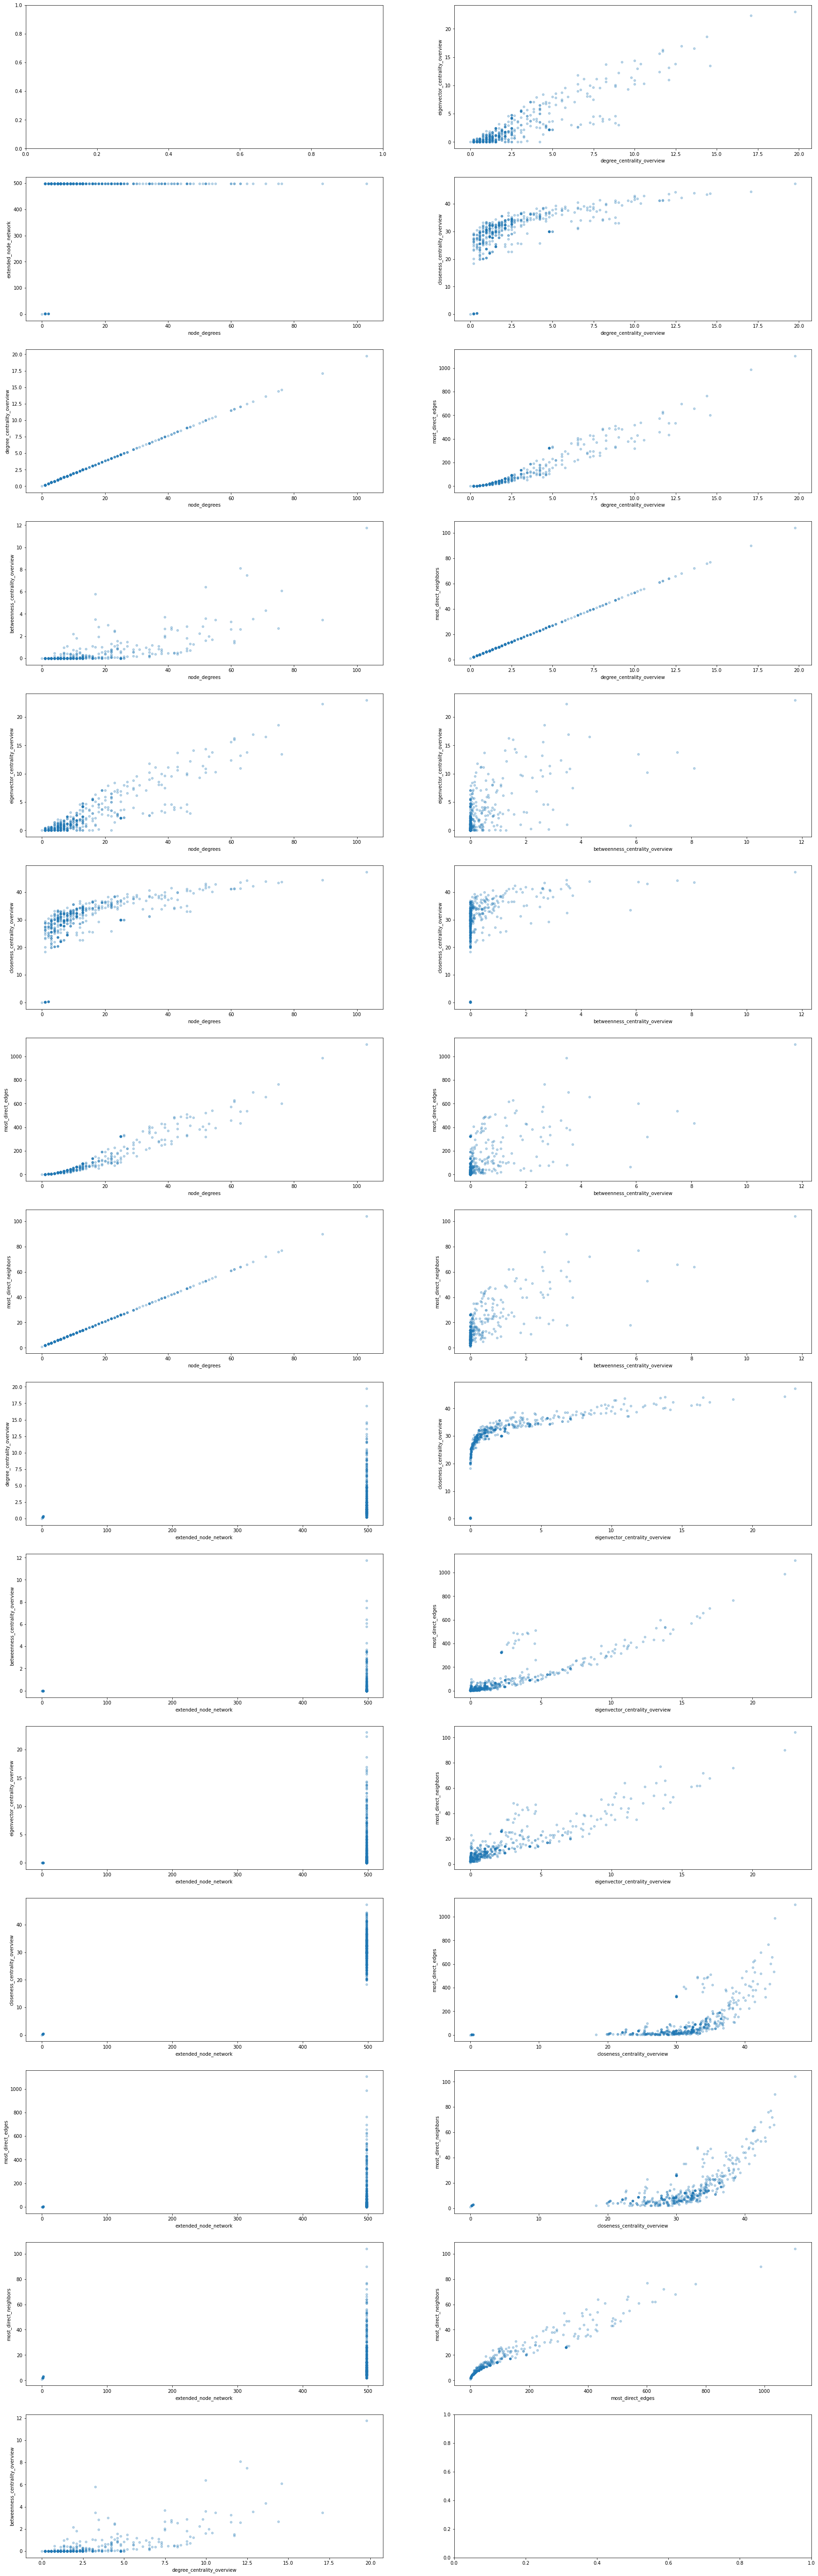

In [115]:
import matplotlib.pyplot as plt
import itertools
cols = df_node_data.columns
col_combos = list(itertools.combinations(cols, 2))


figure, axis = plt.subplots(15, 2, figsize=(30,100))

column_no = 0
row_no = 0
iteration_no = 0
for columns in col_combos:
    column1, column2 = columns
    
    row_no += 1
    iteration_no += 1
    
    if row_no == 15:
        column_no = 1
        row_no = 0

    ax = df_node_data.plot(x=column1, y=column2, kind='scatter', alpha=0.3, ax=axis[row_no, column_no])
  
plt.show()